# Analysis of the online model

In [1]:
from __future__ import annotations

import os
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))

import json
from typing import List

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.extra.io import save_plot

matplotlib.rcParams['font.family'] = "monospace"
%matplotlib inline

In [2]:
folder = '../data/old/online'
for filename in os.listdir(folder):
    if 'online' in filename:
        with open(f'{folder}/{filename}') as file:
            json_data = json.load(file)
            print(f'{filename}: {len(json_data)}')

batch_online_paper_r_s8_dt07-27_00-30-22.json: 20
batch_online_paper_r_s6_dt07-27_00-30-22.json: 20
batch_online_paper_r_s8_dt07-31_10-07-43.json: 20
batch_online_paper_r_s8_dt07-18_01-20-21.json: 4
batch_online_paper_r_s6_dt07-24_13-00-33.json: 1


In [6]:
results_filename = f'{folder}/batch_online_paper_r_s8_dt07-31_10-07-43.json'
results_filename = '../data/online/batch_online_synthetic_r_s4_dt06-29_13-26-32.json'

with open(results_filename) as file:
    results_data = json.load(file)

In [9]:
batch_lengths = [batch_length for batch_length in results_data[0].keys() if batch_length != 'model']
algos = list(results_data[0]['batch length 1'].keys())
algo_names = ['Non-elastic Optimal', 'Greedy Algorithm']
{'Batch length': batch_lengths, 'Algorithms': algos, 'Algo Names': algo_names}

{'Batch length': ['batch length 1', 'batch length 3', 'batch length 6'],
 'Algorithms': ['Non-elastic Optimal',
  'Greedy Utility * deadline / Sum, Product, Pow percent sum'],
 'Algo Names': ['Non-elastic Optimal', 'Greedy Algorithm']}

### Task arrival over time

In [19]:
model_tasks = results_data[0]['model']['tasks']
max_auction_time = max(task['auction time'] for task in model_tasks)
max_auction_time

249

Text(0.5, 1.0, 'Task Arrival at each time step')

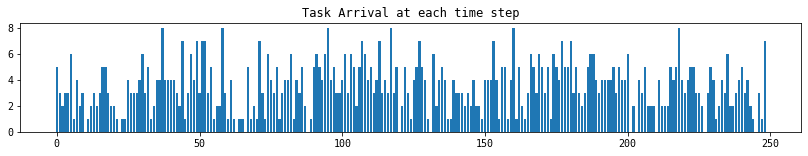

In [20]:
tasks_per_time_step = [
    sum(task['auction time'] == time_step for task in model_tasks)
    for time_step in range(max_auction_time)
]

_, ax_task_arrival = plt.subplots(figsize=(14, 2))
ax_task_arrival.bar(np.arange(max_auction_time), tasks_per_time_step)
ax_task_arrival.set_title('Task Arrival at each time step')

### Resource batch results

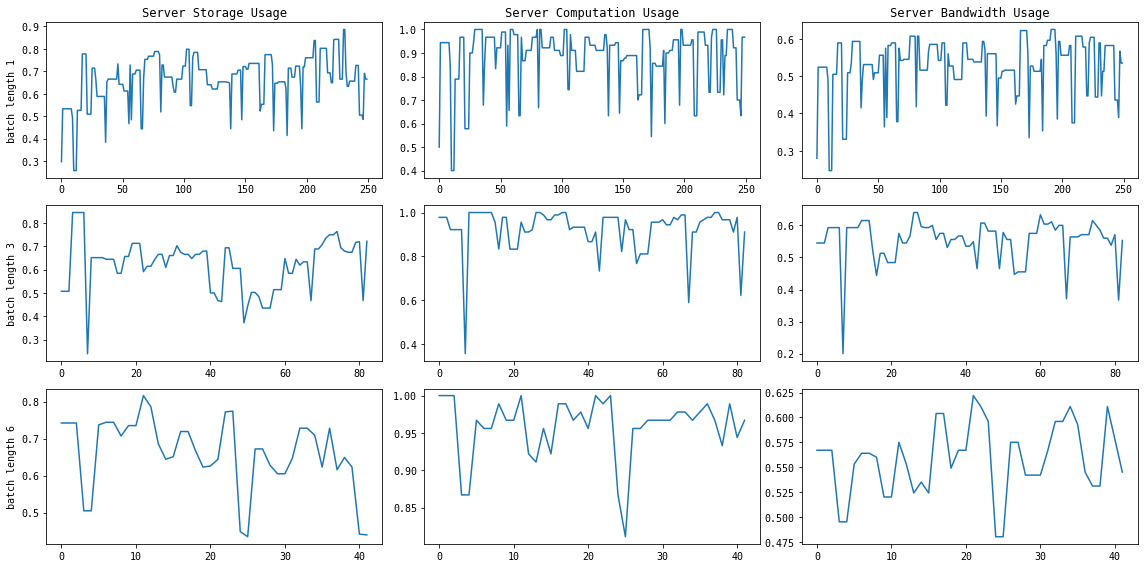

In [26]:
fig, axs = plt.subplots(3, 3, figsize=(16, 8))
for pos, title in enumerate(('Server Storage Usage', 'Server Computation Usage', 'Server Bandwidth Usage')):
    axs[0][pos].set_title(title)
    
for ax, batch_length in zip(axs, batch_lengths):
    ax[0].set_ylabel(batch_length)
    batch_time_steps = len(results_data[0][batch_length][algos[0]]['server storage used']['server 0'])
    for resource_ax, resource in zip(ax, ('server storage used', 'server computation used', 'server bandwidth used')):
        resource_ax.plot(np.arange(batch_time_steps), results_data[0][batch_length][algos[0]][resource]['server 0'])
        
plt.tight_layout()

## Overall results

In [37]:
for algo in algos:
    print(f'Algorithm: {algo}')
    for batch_length in batch_lengths:
        tasks_allocated = np.mean([result[batch_length][algo]['percentage tasks allocated'] 
                                   for result in results_data])
        social_welfare = np.mean([result[batch_length][algo]['social welfare'] 
                                  for result in results_data])
        social_welfare_percent = np.mean([result[batch_length][algo]['social welfare percent']
                                          for result in results_data])
        print(f'{batch_length} - Tasks allocated: {tasks_allocated:.3f}, social welfare: {social_welfare}, '
              f'social welfare percent: {social_welfare_percent:.3f}')

Algorithm: Non-elastic Optimal
batch length 1 - Tasks allocated: 0.239, social welfare: 12052.55, social welfare percent: 0.275
batch length 3 - Tasks allocated: 0.203, social welfare: 11158.6, social welfare percent: 0.256
batch length 6 - Tasks allocated: 0.162, social welfare: 8741.45, social welfare percent: 0.213
Algorithm: Greedy Utility * deadline / Sum, Product, Pow percent sum
batch length 1 - Tasks allocated: 0.354, social welfare: 17575.9, social welfare percent: 0.401
batch length 3 - Tasks allocated: 0.296, social welfare: 15963.15, social welfare percent: 0.366
batch length 6 - Tasks allocated: 0.235, social welfare: 12177.2, social welfare percent: 0.297


In [33]:
data = [] 
for pos, result in enumerate(results_data):
    for length, length_name in zip(batch_lengths, ('Online', 'Batch Length 3', 'Batch Length 6')):
        for algo, algo_name in zip(algos, algo_names):
            data.append([length_name, algo_name, result[length][algo]['social welfare'], pos])
    
online_df = pd.DataFrame(data, columns=['Batch Length', 'Algorithm', 'Social Welfare', 'repeat'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save file location: figs/eps/online_batch_lengths.eps
Save file location: figs/png/online_batch_lengths.png
Save file location: figs/pdf/online_batch_lengths.pdf


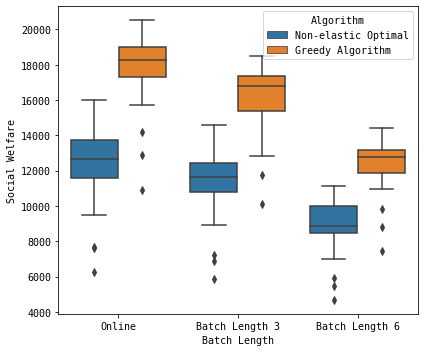

In [34]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.boxplot(x='Batch Length', y='Social Welfare', hue='Algorithm', data=online_df, ax=ax)
plt.tight_layout()
save_plot('online_batch_lengths')